In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import KFold
from sklearn.metrics import ndcg_score

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import xml.etree.ElementTree as Et

from collections import Counter
import re
from time import sleep


In [4]:
#load metadata.csv
def prepTREC(fname):
    #get valid TREC ids for this round
    TRECids = []
    f = open(fname)
    for line in f.readlines():
        if line[-1] == '\n':
            line = line[:-1]
        TRECids.append(line)
    f.close()
    
    metadata = pd.read_csv("/home/tmschoegje/Desktop/caos-19/metadata.csv")
    #now we filter all TREC ids we don't need
    #print(np.array(metadata).shape)
    #print(np.array(TRECids).shape)
    metadata = metadata[metadata.cord_uid.isin(TRECids)]
    #there's 33 duplicates (same paper from multiple sources)
    metadata.drop_duplicates(subset='cord_uid', keep='first', inplace=True)
    
    return metadata

# now get the abstracts for these items
def getJournal(cord_id, metadata):
    journal = metadata[metadata['cord_uid'] == cord_id]['journal']

    #do some preprocessing
    journal = journal.to_string()
    #print(" ".join(journal.split(" ")[4:]))
    
    return " ".join(journal.split(" ")[4:])



In [5]:
#classification with confidence
rnd3classes = [2, 0, 3, 0, 3, 7, 7, 7, 6, 5, 4, 5, 0, 0, 0, 0, 4, 5, 5, 1, 0, 1, 1, 1, 1, 7, 7, 3, 3, 3, 2, 2, 3, 3, 9, 2, 2, 3, 3, 2, 1, 3, 8, 5, 8]
rnd3confidence = [1, 1, 1, 0.5, 0.5, 1, 1, 0.5, 0.5, 1, 0, 0.5, 1, 0, 1, 1, 0.75, 0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 1, 0.5, 1, 1, 1, 0, 1, 1, 0, 0, 0.5, 1, 0, 0, 1, 0, 0, 0, 0, 0]
tasknames = ["transmission incubation environment", "risk factors", "genetics origin evolution", "vaccines therapeutics", "medical care","effectiveness non pharmaceutical interventions", "diagnostics surveillance", "geographic spread", "ethical social considerations", "information sharing collaboration"]
print(len(rnd3classes))
#alias
manual_classification = rnd3classes
metadata = prepTREC('../trecdata/docids-rnd3.txt')

qrels = []         #contains topic, cord_uid, qrel, assessround qrels
doc_sets = []      #contains qrels per task
journal_sets = []  #contains individual fulltext abstracts

for line in open('/home/tmschoegje/Desktop/caos-19/trecdata/qrels-covid_d3_j0.5-3.txt').readlines():
    vals = line.strip().split(" ")
    #if relevant, add
    if(float(vals[3]) > 0):
        #topic, cord_uid, qrel, assessround
        qrels.append([int(vals[0]), vals[2], float(vals[3]), float(vals[1])])
qrels = np.array(qrels, dtype="O")

    
#store documents for each task here    
for i in range(10):
    doc_sets.append([])
    journal_sets.append([])

#for each topic, get all documents 
for topic in range(1, 41):
    docs = qrels[qrels[:,0] == topic]
    
    #add these documents to the documents for each task
    for np_array in docs:
        doc_sets[manual_classification[topic - 1]].append(list(np_array))
        
# we have no examples of 8 and 9 - which makes sense when you look at those task descriptions

for task_id, task_docs in enumerate(doc_sets):
    for doc in task_docs:
        journal_sets[task_id].append(getJournal(doc[1], metadata))

        
print('ready')

45


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


ready


In [6]:
#print(pd.Series(task_journals).value_counts(normalize=True).nlargest(3))

#print(np.max(pd.Series(task_journals).value_counts()))
print('hi')

hi


(10001, 4)
(10,)
(10,)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


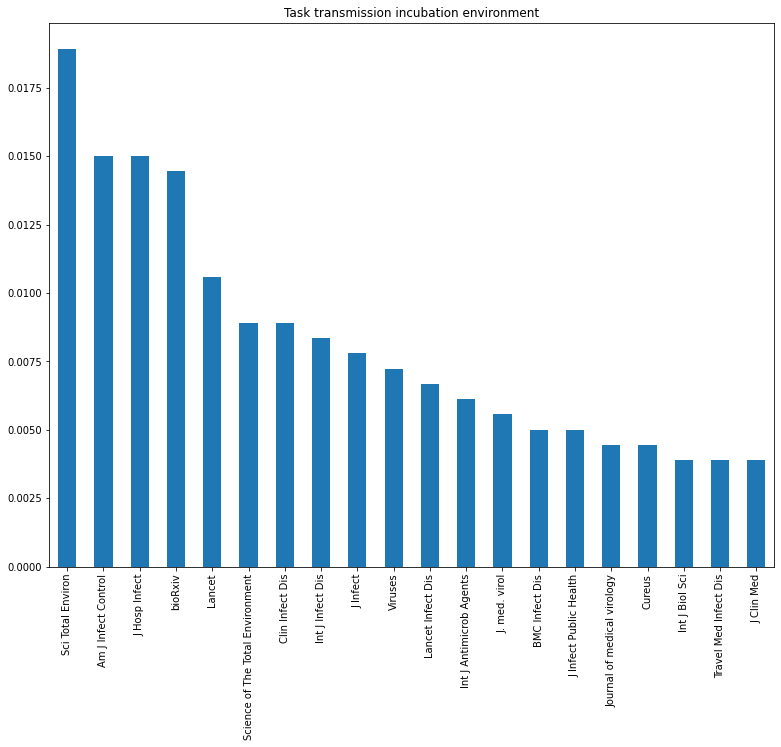

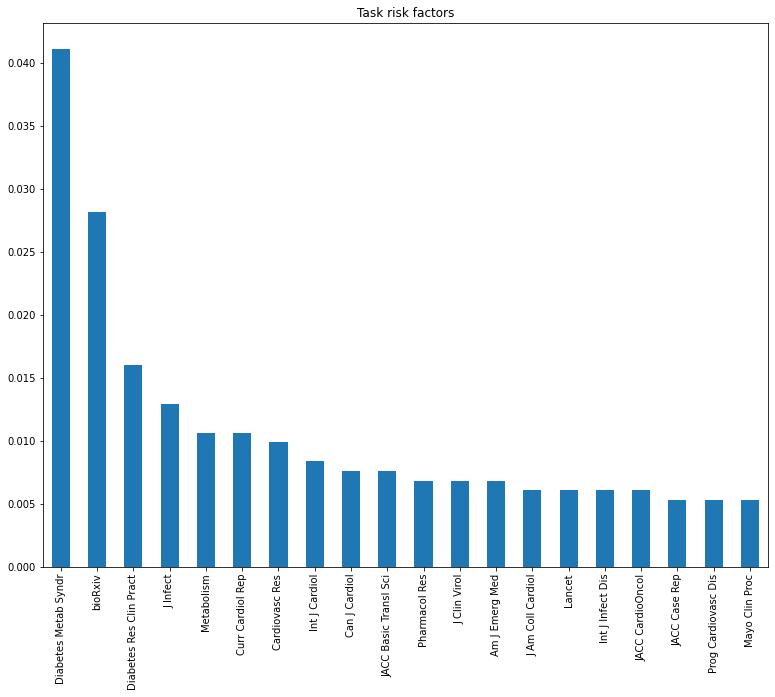

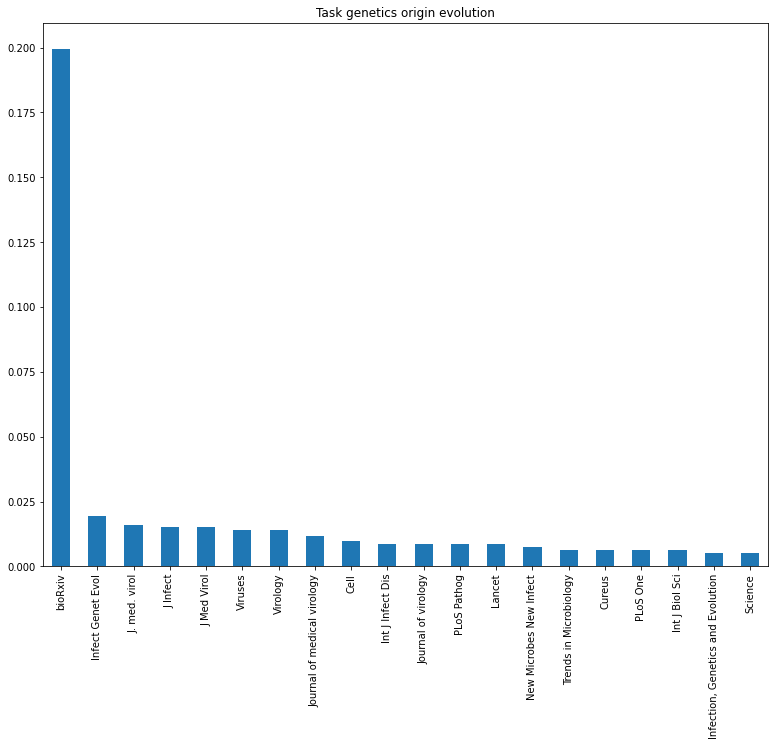

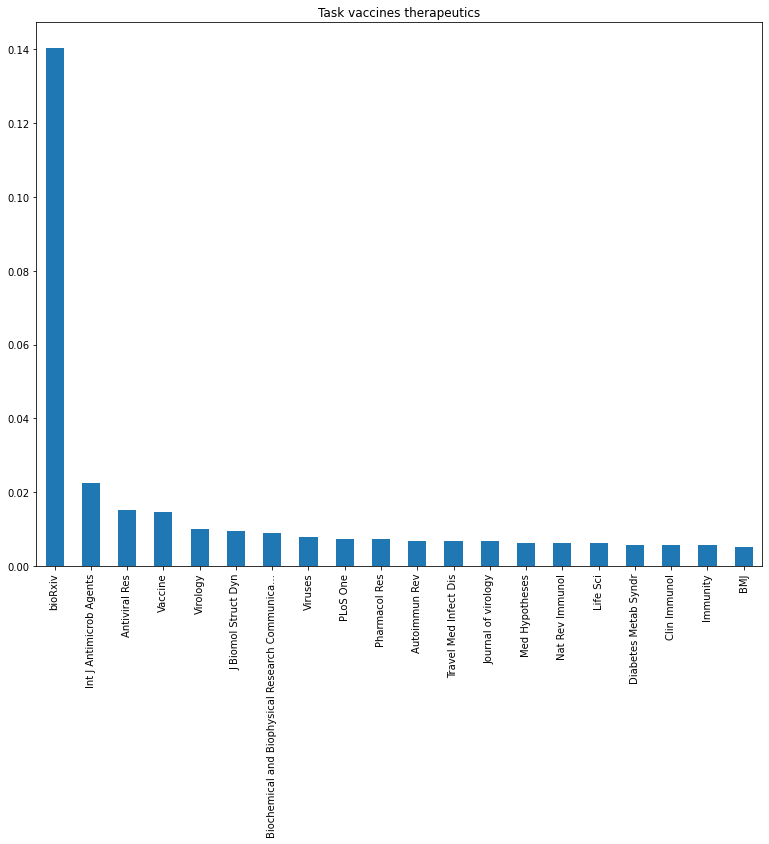

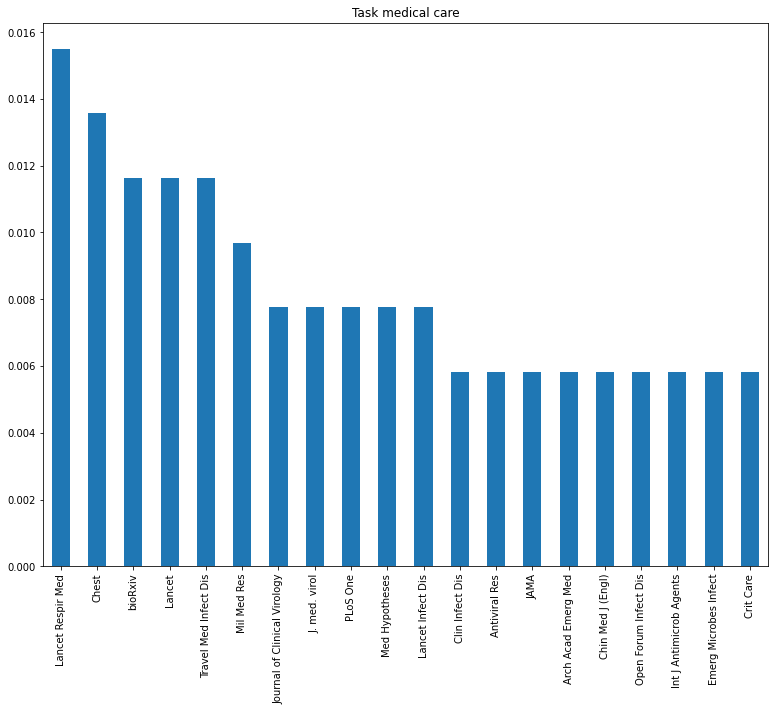

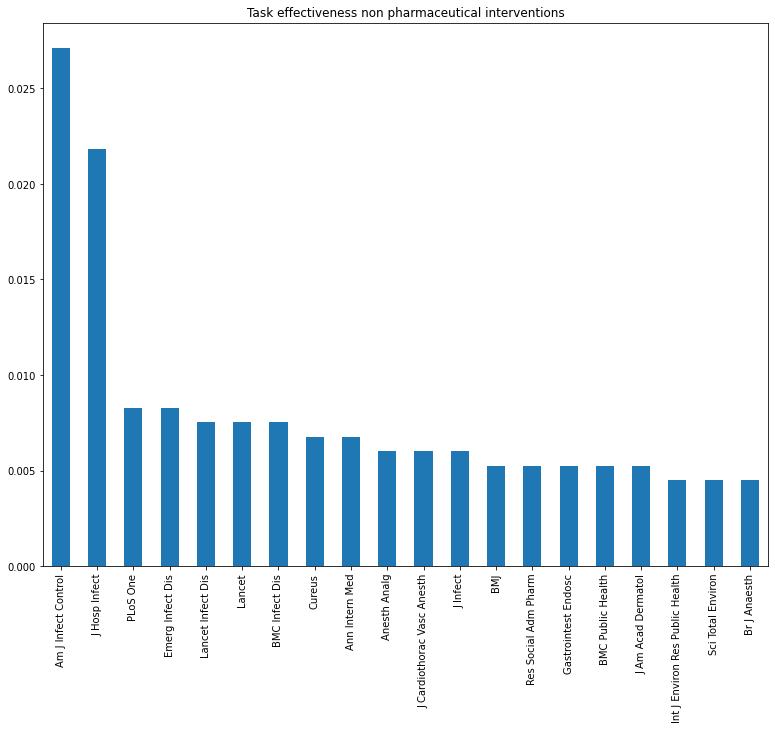

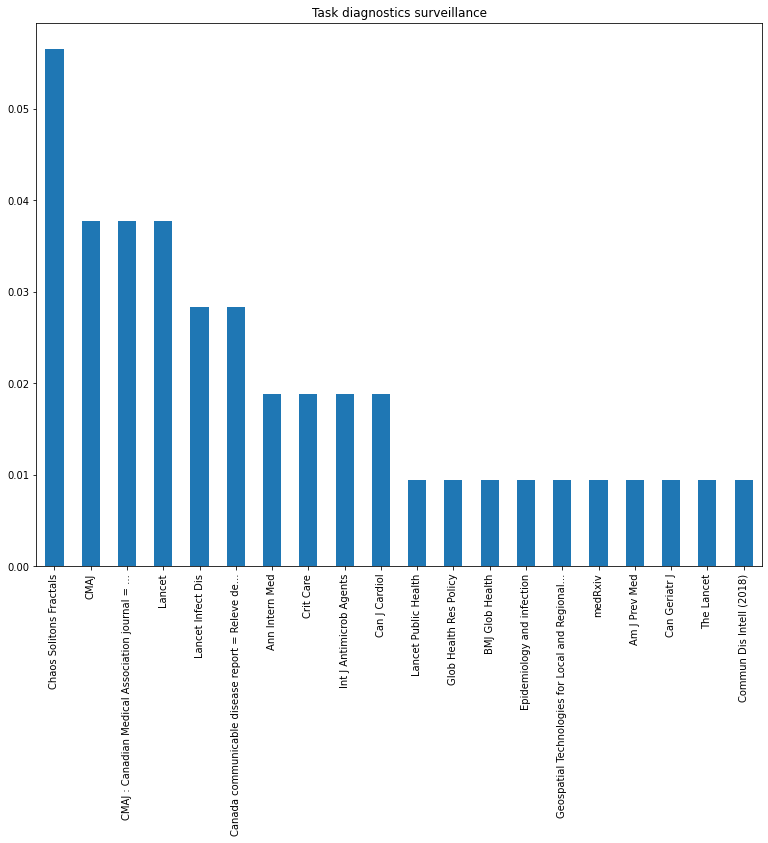

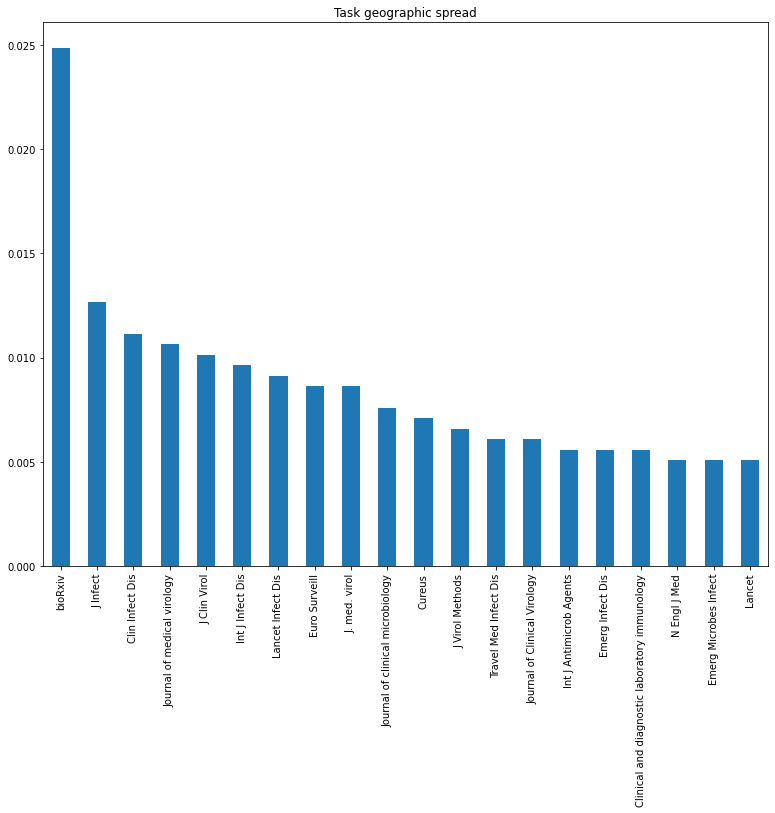

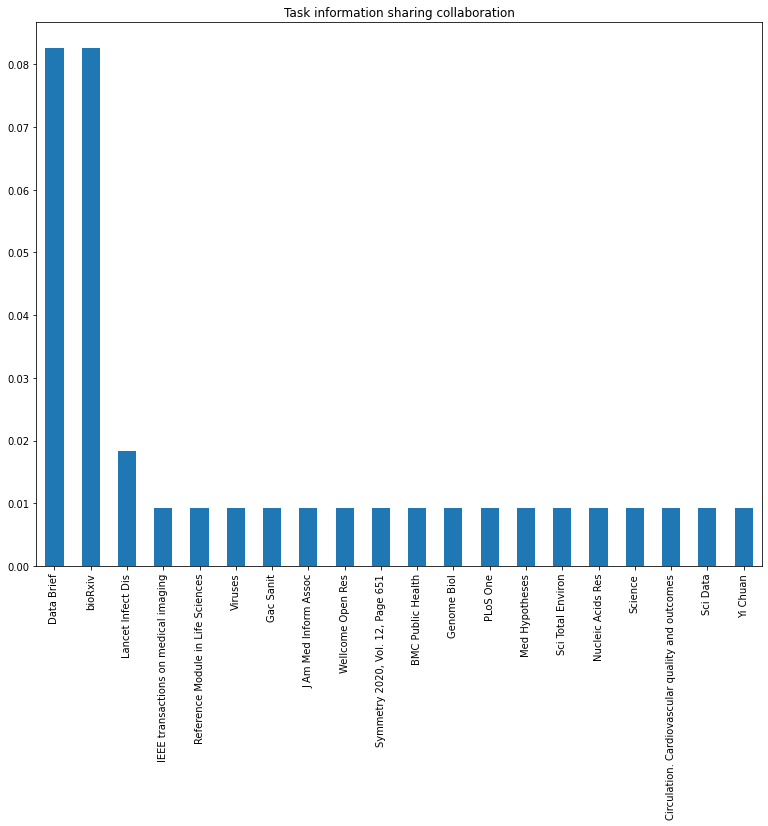

In [7]:
print(np.array(qrels).shape)
print(np.array(doc_sets).shape)
print(np.array(journal_sets).shape)

lookup = dict()

for task_id, task_journals in enumerate(journal_sets):
    if(len(task_journals) > 0):
        pd.Series(task_journals).value_counts(normalize=True).drop('NaN').nlargest(20).plot(title='Task ' + tasknames[task_id], kind='bar', figsize=(13, 10))
        lookup[task_id] = pd.Series(task_journals).value_counts(normalize=True).drop('NaN').to_dict()
        plt.show()
    

In [6]:
#So lets use these as the prior probability of a journal given a task   journal | task
#We want p(relevant | task, journal)
#we have p(journal | task), p(task|journal)

key = 'bioRxiv'
print(key)
for task in range(10):
    if task in lookup:
        if key in lookup[task]:
            print(lookup[task][key])
        
key = 'Lancet'
print(key)
for task in range(10):
    if task in lookup:
        if key in lookup[task]:
            print(lookup[task][key])


bioRxiv
0.014468558708959377
0.028136882129277566
0.19957081545064378
0.14033264033264034
0.011627906976744186
0.0030097817908201654
0.02483527622909275
0.08256880733944955
Lancet
0.010573177518085699
0.006083650190114068
0.008583690987124463
0.004158004158004158
0.011627906976744186
0.007524454477050414
0.03773584905660377
0.00506842372022301


In [17]:
#Some helper functions

#Used to read in a run's ranking
def readAnserini(fname, k=1000):
    res=[]
    f = open(fname)
    #f.readline()
    prev_topic = 0
    topic_count = 0
    for line in f.readlines():
        vals = line.strip().split(" ")
        if(vals[0] != prev_topic):
            prev_topic = vals[0]
            topic_count = 0

        if(topic_count < k):
            #topic, rank, cord_id, score
            res.append([vals[0], vals[3], vals[2], vals[4]])
    return res

#Used to prepare results in submission format
def writeBM25results(results, runtitle):
    f = open(runtitle, "w")
    #topic, rank, cord_id, score
    for result in results:
        #print(result)
        f.write(result[0] + " Q0 " + result[2] + " 1 " + str(result[3]) + " " + runtitle + "\n")
    f.close()
    
#Get the prior probability of a journal given a task
def getPrior(cord_uid, metadata, task_id):
    
    task = int(task_id)
    journal = metadata[metadata['cord_uid'] == cord_uid]['journal'].to_string(index=False).strip()
    
    if task in lookup:
        if journal in lookup[task]:
            #print(journal)
            #print(task)
            return lookup[task][journal]
        else: 
            return -10
    else:
        return -10

def readTopics(fname):
    root = Et.parse(fname).getroot()
    topics = []
    for num, topic in enumerate(root):
        #print(topic[0].text) #query
        topics.append([topic[0].text, rnd3classes[num], topic[2].text])
        #print(topic[1].text) #question
        #print(topic[2].text) #narrative
    return topics

#load the qrels file
def getqrels(fname):
    qrels = []
    for line in open(fname).readlines():
        vals = line.strip().split(" ")
        #if relevant
        #if(float(vals[4]) > 0):
            #topic, cord_uid, qrel, assessround
        qrels.append([int(vals[0]), vals[2], float(vals[3]), float(vals[1])])

    qrels = np.array(qrels, dtype="O")
    return qrels

#find qrel for a cord uid
def get_qrel(cord_uid, topic_id, qrels):

    topicrels = qrels[qrels[:,0] == topic_id]

    qrel_uids = [qrel[1] for qrel in topicrels]
    #print(qrel_uids.index(cord_uid))
    index = qrel_uids.index(cord_uid)
    #print(qrels[index,2])
    if(qrels[index,2] > 0):
        return 1
    else:
        return 0


In [10]:
#ndcg after filtering unknown docs - sakai 2007 says this is more stable than bpref

#Note: it's nicer to do NDCG over all known qrels. 
#Implementation of this was limited - so we only considered the qrels in the top 30k documents

def ndcg(runname, qrelname):
    qrels = getqrels(qrelname)
    
    preds = []
    
    #use these so we can keep track of how many ranked docs per topic
    #we are willing to parse at max
    topic = 0
    counttopic = 0
    
    #first parse predictions
    for line in open(runname).readlines():
        
        #topic, unused, cord_uid, rank, score, runname
        vals = line.strip().split(" ")
        
        if(topic != int(vals[0])):
            topic = int(vals[0])
            counttopic = 0
            
        if(counttopic < 1000):
            #topic, cord_uid, score, rank
            preds.append([int(vals[0]), vals[2], float(vals[4]), int(vals[3])])
        counttopic +=1
        
    #print('hi')
    #print(len(preds))
    #print(len(qrels))
    knownpreds = []
    
    for num, pred in enumerate(preds):
        #get qrels for the given topic
        qrels_topic = qrels[qrels[:,0] == pred[0]]
        qrel_uids = [val[1] for val in qrels_topic]

        #filter all preds not in qrels
        if(pred[1] in qrel_uids):
            #add known prediction with predicted score and real score
            knownpreds.append([pred[0], pred[1], pred[2], get_qrel(pred[1], pred[0], qrels_topic), pred[3]])
            
    knownpreds = np.array(knownpreds, dtype="O")
    
    #TODO update for round2+ topics
    ndcgs = []
    task_ndcgs = []
    for i in range(10):
        task_ndcgs.append([])
        
    for t in range(1, 41):
        #print(np.array(knownpreds).shape)
        
        knownpreds_t = knownpreds[knownpreds[:,0] == t]
        
        #cross validation on knownpreds_t
        #If this topic has at least 5 documens with known qrels, we compute it using 5x cross validation
        #Otherwise, we ignore the ndcg for this topic. Afterwards, average for all topics
        
        n_splits = 5
        if(len(knownpreds_t) > 5):
            kf = KFold(n_splits)
            for train_index, test_index in kf.split(knownpreds_t):
        
                sortedqrel = []
                sortedqpred = []
                for pred_ind, pred in enumerate(knownpreds_t):
                    if pred_ind in train_index:
                        #get corresponding pred's qrel
                        sortedqrel.append(pred[3])#get_qrel(pred[1], pred[0], qrels))
                        #ground truth
                        sortedqpred.append(pred[2])        
            
                if(len(sortedqrel) > 1):
                    ndcgs.append(ndcg_score(np.asarray([sortedqrel]), np.asarray([sortedqpred])))
                    task_ndcgs[rnd3classes[t]].append(ndcg_score(np.asarray([sortedqrel]), np.asarray([sortedqpred]), k=10))
                else:
                    print('how did i get here')
           
        else:
            pass
        
    #used to test task ndcgs
    if(True):
        for task, ndcg in enumerate(task_ndcgs):
            print('Task ' + str(task) + ' ndcg ' + str(np.mean(ndcg)))
        
    return np.mean(ndcgs)

print(ndcg("/home/tmschoegje/Desktop/caos-19/runs/testrun-best-rnd3.run", '/home/tmschoegje/Desktop/caos-19/trecdata/qrels-covid_d3_j0.5-3.txt'))
print('baseline:')
print(ndcg("/home/tmschoegje/Desktop/caos-19/baselines/anserini.covid-r4.paragraph.qdel.bm25-1.txt", '/home/tmschoegje/Desktop/caos-19/trecdata/qrels-covid_d3_j0.5-3.txt'))


Task 0 ndcg 0.5694554458034512
Task 1 ndcg 0.631890601324307
Task 2 ndcg 0.6105839835008756
Task 3 ndcg 0.6523606130464105
Task 4 ndcg 0.5744785387703233
Task 5 ndcg 0.6573310629550739
Task 6 ndcg 0.9382255842521214
Task 7 ndcg 0.6247880454708393
Task 8 ndcg nan
Task 9 ndcg 0.0
0.808520734681418
baseline:


/home/tmschoegje/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tmschoegje/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [11]:
docid_path = '/home/tmschoegje/Desktop/caos-19/trecdata/docids-rnd3.txt'
train_path = '/home/tmschoegje/Desktop/caos-19/trecdata/qrels-rnd2.txt'
test_path = '/home/tmschoegje/Desktop/caos-19/trecdata/qrels-covid_d3_j0.5-3.txt'
topics_path = '/home/tmschoegje/Desktop/caos-19/trecdata/topics-rnd3.xml'
train_n = 35
test_n = 40

valid = set()
with open(docid_path, 'r') as f:
    for line in f:
        valid |= {line.strip()}

tree = Et.parse(topics_path)
root = tree.getroot()
topics = [root[i][0].text for i in range(train_n)]
nars =  [root[i][1].text for i in range(train_n)]

train_ids = [[] for i in range(train_n)]
train_vals = [[] for i in range(train_n)]
with open(train_path, 'r') as f:
    for line in f:
        topicno, iteration, docid, relevance = line.strip().split(' ')
        train_ids[int(topicno) - 1].append(docid)
        train_vals[int(topicno) - 1].append(relevance)

test_ids = [[] for i in range(test_n)]
test_vals = [[] for i in range(test_n)]
true_ids = [[] for i in range(test_n)]
with open(test_path, 'r') as f:
    for line in f:
        topicno, iteration, docid, relevance = line.strip().split(' ')
        test_ids[int(topicno) - 1].append(docid)
        test_vals[int(topicno) - 1].append(relevance)
        if(int(relevance) > 0):
            true_ids[int(topicno) - 1].append(docid)

In [14]:
#true one
def compute_map(run_name):
    #used to limit how many preds we consider per topic (speeding up using the anserini baseline)
    last_topic = 0
    count_topic = 0
    
    #let's keep track of how many results are judged, and see if it corresponds with the leaderboards' j@ scores
    judged = 0
    counted = 0
    
    #average precision variables
    #p@k
    ap = 0
    judged_topic = 0
    gtp = 0
    aps = []
    allqrels = 0
    vals = ""

    for line in open(run_name, 'r').readlines():
         
        #topic, unused, cord_uid, rank, score, runname
        vals = line.strip().split(" ")
        
        #have we reached a new topic
        if(last_topic != int(vals[0])):
            #store AP from last topic
            if(last_topic != 0):
                #print(ap)
                #aps.append((1.0 / qrels) * ap)
                aps.append((1.0 / len(true_ids[int(vals[0]) - 1])) * ap)

            last_topic = int(vals[0])
            count_topic = 0            
            qrels = 0
            ap = 0
            
        #trec considers only the first 1000 predictions for each topic
        if(count_topic < 1000):
            count_topic += 1
            qrel = 0

            #if we know this value is true for this topic
            if vals[2] in true_ids[int(vals[0])-1]:
                qrel = 1
                qrels += 1
                allqrels +=1
                
            #add to the average precision
            #print()
            #print(qrels)
            #print(count_topic)
            ap += ((qrels / count_topic) * qrel)

    #aps.append((1.0 / qrels) * ap)
    aps.append((1.0 / len(true_ids[int(vals[0]) - 1])) * ap)
 
    #print(aps)
    return np.mean(aps)


#for topic in true_ids:
#    print(len(topic))
    
#print(compute_map("/home/tmschoegje/Desktop/caos-19/baselines/anserini.final-r3.rf.txt"))
print(compute_map("/home/tmschoegje/Desktop/caos-19/trecdata/r3.rf"))
print(compute_map("/home/tmschoegje/Desktop/caos-19/trecdata/ruir-round3.txt"))
print(compute_map("/home/tmschoegje/Desktop/caos-19/trecdata/qexp-q0.4n0.4t0.2.run"))
print(compute_map("/home/tmschoegje/Desktop/caos-19/baselines/r3.fusion1.txt"))
print(compute_map("/home/tmschoegje/Desktop/caos-19/baselines/r3.fusion2.txt"))

#TODO which set of true ids? shoudl we only count those in map

#map for this run should be 0.2817

0.20040865070199604
0.0661914426251879
0.12464951710452392
0.16988628873571665
0.19709898422847888


In [23]:

from tqdm import tqdm

# Rerank by journal
def rerank(res, topics, mixer):
    metadata = prepTREC('../trecdata/docids-rnd3.txt')
    
    priorscores = []
    scores = []
    for i in tqdm(range(0, len(res))):
        #p(doc | p(journal | task) * p(task))
                                #id, metadata, task
        #print(results)
        p = getPrior(res[i][2], metadata, res[i][0])
        #how much should we boost?
        #if unknown, add nothing
        if(p == -10):
            priorscores.append(0)
        #else, boost by journal prior (m3 says how strong the boost is)
        else:
            #with task prior 
            #priorscores.append(m3 * (p * rnd3confidence[int(result[0])]) )
            
            #without task prior
            priorscores.append(m3 * p)
        scores.append(float(res[i][3]))
    
    #normalize scores
    scores = [float(score) / max(scores) for score in scores]        
    
    for i, val in enumerate(priorscores):
        res[i][3] = scores[i] + priorscores[i]
    
    #Some ugly/quick sorting
    def sort_key0(item):
#        print(item[3])
        return item[3]
    def sort_key1(item):
        return item[0]

    res = sorted(res, key=sort_key0, reverse=True)
    res = sorted(res, key=sort_key1, reverse=False)
    
    #print(scores[0:5])
    #print(priorscores[0:5])
    #print(np.array(results)[0:5,3])
    
    return results

# Let's see what linear combination between the run score these two values makes sense
for m3 in (np.linspace(1, 10, 10)):
    
    #This is currently the best run. Differs from the submitted runfile because it is a longer list of ranked
    #qrels that we can use to tune with ndcg
    #results = readAnserini('/home/tmschoegje/Desktop/caos-19/runs/testrun-best-rnd3.run')
    
    #Currently testing on the baseline (using query terms)
    #results = readAnserini('/home/tmschoegje/Desktop/caos-19/runs/testrun-baseline-rnd3.run')
    
    runname = "/home/tmschoegje/Desktop/caos-19/baselines/r3.rf"
#    runname = '/home/tmschoegje/Desktop/caos-19/trecdata/qexp-q0.4n0.4t0.2.run'
    results = readAnserini(runname, 1000)
    #print(results)
    results_reranked = rerank(results, readTopics('../trecdata/topics-rnd3.xml'), m3)
    print('done round')
    #writeBM25results(results_reranked, "/home/tmschoegje/Desktop/caos-19/runs/j|t-" + str(m3) + '.run')
    writeBM25results(results_reranked, "/home/tmschoegje/Desktop/caos-19/runs/jt-" + str(m3) + '.run')
    #print(compute_map("/home/tmschoegje/Desktop/caos-19/runs/jt-" + str(m3) + '.run'))
    #print(ndcg("/home/tmschoegje/Desktop/caos-19/runs/j|t-" + str(m3) + '.run', '/home/tmschoegje/Desktop/caos-19/trecdata/qrels-covid_d3_j0.5-3.txt'))

#print('hi')
#m3=3
#results = readAnserini("/home/tmschoegje/Desktop/caos-19/baselines/anserini.covid-r4.paragraph.qdel.bm25-1.txt")

#results_reranked = rerank(results, readTopics('../trecdata/topics-rnd4.xml'), m3)
#writeBM25results(results_reranked, "/home/tmschoegje/Desktop/caos-19/runs/j|t-" + str(m3) + '.run')
#print(ndcg("/home/tmschoegje/Desktop/caos-19/runs/j|t-" + str(m3) + '.run', '../trecdata/qrels-rnd3.txt'))

#baseline we get ndcg .522
#with p(task) as certainty of assigning, we get .537
#without p(task) we get 0.541


#ok we fixed ndcg - what's the new results?


#TODO limit readanserini so we can do quick tests
#use baseline to rerank


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|██████████| 39888/39888 [06:41<00:00, 99.41it/s] 


done round


 74%|███████▎  | 29325/39888 [05:08<01:51, 95.05it/s]


KeyboardInterrupt: 

In [ ]:
print(ndcg("/home/tmschoegje/Desktop/caos-19/trecdata/qexp-q0.4n0.4t0.2.run", '/home/tmschoegje/Desktop/caos-19/trecdata/qrels-covid_d3_j0.5-3.txt'))
print(ndcg("/home/tmschoegje/Desktop/caos-19/trecdata/qexp-q0.5n0.5t0.run", '/home/tmschoegje/Desktop/caos-19/trecdata/qrels-covid_d3_j0.5-3.txt'))

In [ ]:
print(ndcg("/home/tmschoegje/Desktop/caos-19/runs/j|t-" + str(0.0) + '.run', '../runs/testrun-best-rnd3.run'.txt'))
           
           
           

In [17]:
#check out how qrels are distributed over topics
#check what tasks/topics we do well
    #ndcg per task
    #ndcg per topic
print('hi')

hi


In [34]:
#lets check automatic v manual classification




task_1_short = "transmission incubation environment"
task_2_short = "risk factors"
task_3_short = "genetics origin evolution"
task_4_short = "vaccines therapeutics"
task_5_short = "medical care"
task_6_short = "effectiveness non pharmaceutical interventions"
task_7_short = "diagnostics surveillance"
task_8_short = "geographic spread"
task_9_short = "ethical social considerations"
task_10_short = "information sharing collaboration"

task_1 = "What is known about transmission, incubation, and environmental stability? What do we know about natural history, transmission, and diagnostics for the virus? What have we learned about infection prevention and control? Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery. Prevalence of asymptomatic shedding and transmission (e.g., particularly children). Seasonality of transmission. Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding). Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood). Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic). Natural history of the virus and shedding of it from an infected person. Implementation of diagnostics and products to improve clinical processes. Disease models, including animal models for infection, disease and transmission. Tools and studies to monitor phenotypic change and potential adaptation of the virus. Immune response and immunity. Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings. Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings. Role of the environment in transmission"
task_2 = "What do we know about COVID-19 risk factors? What have we learned from epidemiological studies? Data on potential risks factors. Smoking, pre-existing pulmonary disease. Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities. Neonates and pregnant women. Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences. Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors. Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups. Susceptibility of populations. Public health mitigation measures that could be effective for control."
task_3 = "What do we know about virus genetics, origin, and evolution? What do we know about the virus origin and management measures at the human-animal interface? Real-time tracking of whole genomes and a mechanism for coordinating the rapid dissemination of that information to inform the development of diagnostics and therapeutics and to track variations of the virus over time. Access to geographic and temporal diverse sample sets to understand geographic distribution and genomic differences, and determine whether there is more than one strain in circulation. Multi-lateral agreements such as the Nagoya Protocol could be leveraged. Evidence that livestock could be infected (e.g., field surveillance, genetic sequencing, receptor binding) and serve as a reservoir after the epidemic appears to be over. Evidence of whether farmers are infected, and whether farmers could have played a role in the origin. Surveillance of mixed wildlife- livestock farms for SARS-CoV-2 and other coronaviruses in Southeast Asia. Experimental infections to test host range for this pathogen. Animal host(s) and any evidence of continued spill-over to humans. Socioeconomic and behavioral risk factors for this spill-over. Sustainable risk reduction strategies"
task_4 = "What do we know about vaccines and therapeutics? What has been published concerning research and development and evaluation efforts of vaccines and therapeutics? Effectiveness of drugs being developed and tried to treat COVID-19 patients. Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocycline that that may exert effects on viral replication. Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients. Exploration of use of best animal models and their predictive value for a human vaccine. Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents. Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need. Efforts targeted at a universal coronavirus vaccine. Efforts to develop animal models and standardize challenge studies. Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers. Approaches to evaluate risk for enhanced disease after vaccination. Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models in conjunction with therapeutics."
task_5 = "What has been published about medical care? What has been published concerning surge capacity and nursing homes? What has been published concerning efforts to inform allocation of scarce resources? What do we know about personal protective equipment? What has been published concerning alternative methods to advise on disease management? What has been published concerning processes of care? What do we know about the clinical characterization and management of the virus? Resources to support skilled nursing facilities and long term care facilities. Mobilization of surge medical staff to address shortages in overwhelmed communities. Age-adjusted mortality data for Acute Respiratory Distress Syndrome (ARDS) with/without other organ failure – particularly for viral etiologies. Extracorporeal membrane oxygenation (ECMO) outcomes data of COVID-19 patients. Outcomes data for COVID-19 after mechanical ventilation adjusted for age. Application of regulatory standards (e.g., EUA, CLIA) and ability to adapt care to crisis standards of care level. Approaches for encouraging and facilitating the production of elastomeric respirators, which can save thousands of N95 masks. Best telemedicine practices, barriers and facilitators, and specific actions to remove/expand them within and across state boundaries. Guidance on the simple things people can do at home to take care of sick people and manage disease. Oral medications that might potentially work. Use of AI in real-time health care delivery to evaluate interventions, risk factors, and outcomes in a way that could not be done manually. Best practices and critical challenges and innovative solutions and technologies in hospital flow and organization, workforce protection, workforce allocation, community-based support resources, payment, and supply chain management to enhance capacity, efficiency, and outcomes. Efforts to define the natural history of disease to inform clinical care, public health interventions, infection prevention control, transmission, and clinical trials. Efforts to develop a core clinical outcome set to maximize usability of data across a range of trials. Efforts to determine adjunctive and supportive interventions that can improve the clinical outcomes of infected patients (e.g. steroids, high flow oxygen). "
task_6 = "What do we know about the effectiveness of non-pharmaceutical interventions? What is known about equity and barriers to compliance for non-pharmaceutical interventions? Guidance on ways to scale up NPIs in a more coordinated way (e.g., establish funding, infrastructure and authorities to support real time, authoritative (qualified participants) collaboration with all states to gain consensus on consistent guidance and to mobilize resources to geographic areas where critical shortfalls are identified) to give us time to enhance our health care delivery system capacity to respond to an increase in cases. Rapid design and execution of experiments to examine and compare NPIs currently being implemented. DHS Centers for Excellence could potentially be leveraged to conduct these experiments. Rapid assessment of the likely efficacy of school closures, travel bans, bans on mass gatherings of various sizes, and other social distancing approaches. Methods to control the spread in communities, barriers to compliance and how these vary among different populations. Models of potential interventions to predict costs and benefits that take account of such factors as race, income, disability, age, geographic location, immigration status, housing status, employment status, and health insurance status. Policy changes necessary to enable the compliance of individuals with limited resources and the underserved with NPIs. Research on why people fail to comply with public health advice, even if they want to do so (e.g., social or financial costs may be too high). Research on the economic impact of this or any pandemic. This would include identifying policy and programmatic alternatives that lessen/mitigate risks to critical government services, food distribution and supplies, access to critical household supplies, and access to health diagnoses, treatment, and needed care, regardless of ability to pay."
task_7 = "What do we know about diagnostics and surveillance? What has been published concerning systematic, holistic approach to diagnostics (from the public health surveillance perspective to being able to predict clinical outcomes)? How widespread current exposure is to be able to make immediate policy recommendations on mitigation measures. Denominators for testing and a mechanism for rapidly sharing that information, including demographics, to the extent possible. Sampling methods to determine asymptomatic disease (e.g., use of serosurveys (such as convalescent samples) and early detection of disease (e.g., use of screening of neutralizing antibodies such as ELISAs). Efforts to increase capacity on existing diagnostic platforms and tap into existing surveillance platforms. Recruitment, support, and coordination of local expertise and capacity (public, private—commercial, and non-profit, including academic), including legal, ethical, communications, and operational issues. National guidance and guidelines about best practices to states (e.g., how states might leverage universities and private laboratories for testing purposes, communications to public health officials and the public). Development of a point-of-care test (like a rapid influenza test) and rapid bed-side tests, recognizing the tradeoffs between speed, accessibility, and accuracy. Rapid design and execution of targeted surveillance experiments calling for all potential testers using PCR in a defined area to start testing and report to a specific entity. These experiments could aid in collecting longitudinal samples, which are critical to understanding the impact of ad hoc local interventions (which also need to be recorded). Separation of assay development issues from instruments, and the role of the private sector to help quickly migrate assays onto those devices. Efforts to track the evolution of the virus (i.e., genetic drift or mutations) and avoid locking into specific reagents and surveillance/detection schemes. Latency issues and when there is sufficient viral load to detect the pathogen, and understanding of what is needed in terms of biological and environmental sampling. Use of diagnostics such as host response markers (e.g., cytokines) to detect early disease or predict severe disease progression, which would be important to understanding best clinical practice and efficacy of therapeutic interventions. Policies and protocols for screening and testing. Policies to mitigate the effects on supplies associated with mass testing, including swabs and reagents. Technology roadmap for diagnostics. Barriers to developing and scaling up new diagnostic tests (e.g., market forces), how future coalition and accelerator models (e.g., Coalition for Epidemic Preparedness Innovations) could provide critical funding for diagnostics, and opportunities for a streamlined regulatory environment. New platforms and technology (e.g., CRISPR) to improve response times and employ more holistic approaches to COVID-19 and future diseases. Coupling genomics and diagnostic testing on a large scale. Enhance capabilities for rapid sequencing and bioinformatics to target regions of the genome that will allow specificity for a particular variant. Enhance capacity (people, technology, data) for sequencing with advanced analytics for unknown pathogens, and explore capabilities for distinguishing naturally-occurring pathogens from intentional. One Health surveillance of humans and potential sources of future spillover or ongoing exposure for this organism and future pathogens, including both evolutionary hosts (e.g., bats) and transmission hosts (e.g., heavily trafficked and farmed wildlife and domestic food and companion species), inclusive of environmental, demographic, and occupational risk factors."
task_8 = "At the time of writing, COVID-19 has spread to at least 114 countries. With viral flu, there are often geographic variations in how the disease will spread and if there are different variations of the virus in different areas. We’d like to explore what the literature and data say about this through this Task. Are there geographic variations in the rate of COVID-19 spread? Are there geographic variations in the mortality rate of COVID-19? Is there any evidence to suggest geographic based virus mutations?"
task_9 = "What has been published concerning ethical considerations for research? What has been published concerning social sciences at the outbreak response? Efforts to articulate and translate existing ethical principles and standards to salient issues in COVID-2019. Efforts to embed ethics across all thematic areas, engage with novel ethical issues that arise and coordinate to minimize duplication of oversight. Efforts to support sustained education, access, and capacity building in the area of ethics. Efforts to establish a team at WHO that will be integrated within multidisciplinary research and operational platforms and that will connect with existing and expanded global networks of social sciences. Efforts to develop qualitative assessment frameworks to systematically collect information related to local barriers and enablers for the uptake and adherence to public health measures for prevention and control. This includes the rapid identification of the secondary impacts of these measures. (e.g. use of surgical masks, modification of health seeking behaviors for SRH, school closures). Efforts to identify how the burden of responding to the outbreak and implementing public health measures affects the physical and psychological health of those providing care for Covid-19 patients and identify the immediate needs that must be addressed. Efforts to identify the underlying drivers of fear, anxiety and stigma that fuel misinformation and rumor, particularly through social media."
task_10 = "What has been published about information sharing and inter-sectoral collaboration? What has been published about data standards and nomenclature? What has been published about governmental public health? What do we know about risk communication? What has been published about communicating with high-risk populations? What has been published to clarify community measures? What has been published about equity considerations and problems of inequity? Methods for coordinating data-gathering with standardized nomenclature. Sharing response information among planners, providers, and others. Understanding and mitigating barriers to information-sharing. How to recruit, support, and coordinate local (non-Federal) expertise and capacity relevant to public health emergency response (public, private, commercial and non-profit, including academic). Integration of federal/state/local public health surveillance systems. Value of investments in baseline public health response infrastructure preparedness. Modes of communicating with target high-risk populations (elderly, health care workers). Risk communication and guidelines that are easy to understand and follow (include targeting at risk populations’ families too). Communication that indicates potential risk of disease to all population groups. Misunderstanding around containment and mitigation. Action plan to mitigate gaps and problems of inequity in the Nation’s public health capability, capacity, and funding to ensure all citizens in need are supported and can access information, surveillance, and treatment. Measures to reach marginalized and disadvantaged populations. Data systems and research priorities and agendas incorporate attention to the needs and circumstances of disadvantaged populations and underrepresented minorities. Mitigating threats to incarcerated people from COVID-19, assuring access to information, prevention, diagnosis, and treatment. Understanding coverage policies (barriers and opportunities) related to testing, treatment, and care."


list_of_tasks = [task_1, task_2, task_3, task_4, task_5, task_6, task_7, task_8, task_9, task_10]
list_of_tasks_short = [task_1_short, task_2_short, task_3_short, task_4_short, task_5_short, task_6_short, task_7_short, task_8_short, task_9_short, task_10_short]

#Let's try to classify each topic by making an index of the tasks
#and ranking them for each query

from rank_bm25 import BM25Okapi


In [35]:
tokenized_corpus = [doc.split(" ") for doc in list_of_tasks]
bm25 = BM25Okapi(tokenized_corpus)

automatic_class = []
agree = 0
for topic in readTopics('../trecdata/topics-rnd3.xml'):
    query = topic[0] #+ " " + topic[2]
    tokenized_query = query.split(" ")
    print(tokenized_query)

    doc_scores = bm25.get_scores(tokenized_query)
    automatic_class.append(np.argmax(doc_scores))
    
    if(np.argmax(doc_scores) == topic[1]):
        agree += 1
    
    print("auto " + str(np.argmax(doc_scores)) + " " + list_of_tasks_short[np.argmax(doc_scores)])
    print("man " + str(topic[1]) + " " + list_of_tasks_short[topic[1]])
    print()
    
print(agree)
    
#rnd3classes = [2, 0, 3, 0, 3, 7, 7, 7, 6, 5, 4, 5, 0, 0, 0, 0, 4, 5, 5, 1, 0, 1, 1, 1, 1, 7, 7, 3, 3, 3, 2, 2, 3, 3, 9, 2, 2, 3, 3, 2]
#rnd3confidence = [1, 1, 1, 0.5, 0.5, 1, 1, 0.5, 0.5, 1, 0, 0.5, 1, 0, 1, 1, 0.75, 0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 1, 0.5, 1, 1, 1, 0, 1, 1, 0, 0, 0.5, 1, 0, 0, 1]

IndexError: list index out of range

In [47]:
#so how are qrels distributed over topics - are some topics harder than others?

qrels_all = []
qrels_good = []
for line in open('/home/tmschoegje/Desktop/caos-19/trecdata/qrels-covid_d3_j0.5-3.txt').readlines():
    vals = line.strip().split(" ")
    qrels_all.append([int(vals[0]), vals[2], float(vals[3]), float(vals[1])])
    #if relevant, add
    if(float(vals[3]) > 0):
        #topic, cord_uid, qrel, assessround
        qrels_good.append([int(vals[0]), vals[2], float(vals[3]), float(vals[1])])
qrels_good = np.array(qrels_good, dtype="O")
qrels_all = np.array(qrels_all, dtype="O")

print(len(qrels_good))
print(len(qrels_all))
print()

#for each topic, get all documents
doccounts_all = []
doccounts_good = []
for topic in range(1, 45):
    docs_all = qrels_all[qrels_all[:,0] == topic] 
    doccounts_all.append(len(docs_all))
    docs_good = qrels_good[qrels_good[:,0] == topic] 
    doccounts_good.append(len(docs_good))
    
for topic, val in enumerate(doccounts_all):
    print(doccounts_good[topic] / doccounts_all[topic])
    
print()
print(doccounts_all)
print(doccounts_good)

3002
12037

0.3544973544973545
0.16772151898734178
0.2786458333333333
0.16
0.2727272727272727
0.592
0.11940298507462686
0.2471655328798186
0.07828282828282829
0.4449152542372881
0.057007125890736345
0.5737704918032787
0.3694690265486726
0.15824915824915825
0.1488469601677149
0.19444444444444445
0.24907063197026022
0.4139194139194139
0.09448818897637795
0.47703180212014135
0.260752688172043
0.2360248447204969
0.2229965156794425
0.1879432624113475
0.2
0.3589041095890411
0.49221183800623053
0.2465753424657534
0.41796875
0.28846153846153844
0.15632754342431762
0.03812316715542522
0.16065573770491803
0.04336734693877551
[378, 316, 384, 425, 385, 375, 335, 441, 396, 236, 421, 366, 452, 297, 477, 396, 269, 273, 381, 283, 372, 322, 287, 282, 375, 365, 321, 219, 256, 208, 403, 341, 305, 392]
[134, 53, 107, 68, 105, 222, 40, 109, 31, 105, 24, 210, 167, 47, 71, 77, 67, 113, 36, 135, 97, 76, 64, 53, 75, 131, 158, 54, 107, 60, 63, 13, 49, 17]


In [66]:
#now the same for tasks
taskcounts_all = []
taskcounts_good = []
for task, docs in enumerate(doc_sets):
    count_all = 0
    count_good = 0
    for doc in docs:
        #if this has no unrelevant documents, the doc_sets are computed with only relevant docs
        #print(doc[2])    
        if doc[2] > 0: #qrel
            count_good += 1
        count_all += 1
    taskcounts_all.append(count_all)
    taskcounts_good.append(count_good)

    #avoid divide by 0
    if(count_all > 0 or count_good > 0):
        print(str(count_good / count_all) + ' ' + list_of_tasks_short[task])
    else:
        print('No examples ' + list_of_tasks_short[task])

print()
print(taskcounts_all)
print(taskcounts_good)



    
#print(doc_sets[0])
"""
So just looking at the proportion of relevant docs

0.21206581352833637 transmission incubation environment
0.26016785022595224 risk factors
0.18716577540106952 genetics origin evolution
0.23220102373196835 vaccines therapeutics
0.1318840579710145 medical care
0.36942675159235666 effectiveness non pharmaceutical interventions
0.07828282828282829 diagnostics surveillance
0.3592814371257485 geographic spread
No examples ethical social considerations
No examples information sharing collaboration

[2735, 1549, 1122, 2149, 690, 1256, 396, 1837, 0, 0]
[580, 403, 210, 499, 91, 464, 31, 660, 0, 0]

And looking at our performance (ndcg)
Task 0 ndcg 0.588245411681926
Task 1 ndcg 0.532086136047341
Task 2 ndcg 0.9593522132494599
Task 3 ndcg 0.5705841689594324
Task 4 ndcg 0.7427080837043373
Task 5 ndcg 0.5536440811230319
Task 6 ndcg 0.6711580717160875
Task 7 ndcg 0.626237798941355
Task 8 ndcg nan
Task 9 ndcg nan
"""

0.21206581352833637 transmission incubation environment
0.26016785022595224 risk factors
0.18716577540106952 genetics origin evolution
0.23220102373196835 vaccines therapeutics
0.1318840579710145 medical care
0.36942675159235666 effectiveness non pharmaceutical interventions
0.07828282828282829 diagnostics surveillance
0.3592814371257485 geographic spread
No examples ethical social considerations
No examples information sharing collaboration

[2735, 1549, 1122, 2149, 690, 1256, 396, 1837, 0, 0]
[580, 403, 210, 499, 91, 464, 31, 660, 0, 0]


'\n0.21206581352833637 transmission incubation environment\n0.26016785022595224 risk factors\n0.18716577540106952 genetics origin evolution\n0.23220102373196835 vaccines therapeutics\n0.1318840579710145 medical care\n0.36942675159235666 effectiveness non pharmaceutical interventions\n0.07828282828282829 diagnostics surveillance\n0.3592814371257485 geographic spread\nNo examples ethical social considerations\nNo examples information sharing collaboration\n\n[2735, 1549, 1122, 2149, 690, 1256, 396, 1837, 0, 0]\n[580, 403, 210, 499, 91, 464, 31, 660, 0, 0]\n'

In [83]:
#test
from pyserini.search import pyquerybuilder


bm25 = ['coronavirus', 'response', 'weather', 'changes', 'Coronavirus', 'CoV', 'coronaviruses', 'responses', 'defenses', 'suppression', 'they', 'thus', 'climatic', 'meteorological', 'climate', 'alterations', 'change', 'differences']
builder = pyquerybuilder.get_boolean_query_builder()
bm25_split = 0.8
    
for b in bm25:
    b = pyquerybuilder.get_term_query(b)
    boostquery = pyquerybuilder.get_boost_query(b, bm25_split/len(bm25))
    builder.add(boostquery, pyquerybuilder.JBooleanClauseOccur['should'].value)


IndexError: list index out of range